In [2]:
import pandas as pd

b = pd.read_csv('/content/drive/MyDrive/data/books.csv')
bt = pd.read_csv('/content/drive/MyDrive/data/book_tags.csv')
t = pd.read_csv('/content/drive/MyDrive/data/tags.csv')

In [3]:
t.head(4)

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-


In [4]:
bt.head(4)

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986


In [5]:
bt['goodreads_book_id'].nunique()

10000

In [6]:
bts = pd.merge(left=t, right=bt, how="left", on="tag_id")
ti_df = pd.DataFrame(b[['goodreads_book_id', 'original_title', 'ratings_count','work_ratings_count', 'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']])
nbts = pd.merge(left=bts, right=ti_df, how="left", on="goodreads_book_id")
nbts.drop(bts.loc[bts['count']<0].index, inplace=True)

nbts.sort_values(by='count', ascending=False).head(10)

,tag_id,tag_name,goodreads_book_id,count,original_title,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
918089,30574,to-read,865,596234,O Alquimista,1299566,1403995,55781,74846,123614,289143,412180,504212
924145,30574,to-read,2429135,586235,Män som hatar kvinnor,1808403,1929834,62543,54835,86051,285413,667485,836050
927113,30574,to-read,18143977,505884,NaN,470001,547827,53413,6209,14527,61020,185239,280832
918007,30574,to-read,3,496107,Harry Potter and the Philosopher's Stone,4602479,4800065,75867,75504,101676,455024,1156318,3011543
919676,30574,to-read,24280,488469,Les Misérables,513407,560132,12505,15225,25914,87461,167385,264147
925851,30574,to-read,11235712,474954,Cinder,427663,454146,41109,12154,18256,66180,150914,206642
922115,30574,to-read,168668,465640,Catch-22,563265,582515,13734,20639,37912,106269,186745,230950
919443,30574,to-read,18405,454565,Gone with the Wind,873981,897303,16050,19996,33136,116160,234290,493721
918388,30574,to-read,4981,443942,"Slaughterhouse-Five, or The Children's Crusade...",846488,891762,19646,24964,45518,152442,300948,367890
918096,30574,to-read,930,436097,Memoirs of a Geisha,1300209,1418172,25605,23500,59033,258700,517157,559782


In [7]:
bts = pd.merge(left=t, right=bt, how="left", on="tag_id")
bts.drop(bts.loc[bts['count']<0].index, inplace=True)
bts.sort_values(by='count', ascending=False).head(10)

,tag_id,tag_name,goodreads_book_id,count
918089,30574,to-read,865,596234
924145,30574,to-read,2429135,586235
927113,30574,to-read,18143977,505884
918007,30574,to-read,3,496107
919676,30574,to-read,24280,488469
925851,30574,to-read,11235712,474954
922115,30574,to-read,168668,465640
919443,30574,to-read,18405,454565
918388,30574,to-read,4981,443942
918096,30574,to-read,930,436097


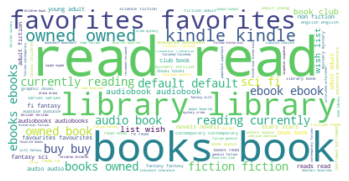

In [8]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)

text = " ".join(review for review in bts['tag_name'])

wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color='white').generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [9]:
bts['tag_name'].value_counts().head(30)

to-read              9983
favorites            9881
owned                9858
books-i-own          9799
currently-reading    9776
library              9415
owned-books          9221
fiction              9097
to-buy               8692
kindle               8316
default              8238
ebook                8053
my-books             7561
audiobook            7242
ebooks               7203
wish-list            7192
my-library           7000
audiobooks           6862
i-own                6670
adult                6604
audio                6548
favourites           6422
novels               5665
own-it               5514
contemporary         5287
read-in-2015         5239
series               5080
e-book               4941
read-in-2016         4940
read-in-2014         4902
Name: tag_name, dtype: int64

In [10]:
r = pd.read_csv('/content/drive/MyDrive/data/ratings.csv')

r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 136.8 MB


In [11]:
rsample = r.sample(frac=0.1, random_state=42)
rsample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597648 entries, 3623535 to 4905054
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  597648 non-null  int64
 1   book_id  597648 non-null  int64
 2   rating   597648 non-null  int64
dtypes: int64(3)
memory usage: 18.2 MB


In [12]:
rsample2 = rsample.sample(frac=0.05, random_state=43)
rsample2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29882 entries, 1582989 to 1096260
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  29882 non-null  int64
 1   book_id  29882 non-null  int64
 2   rating   29882 non-null  int64
dtypes: int64(3)
memory usage: 933.8 KB


In [40]:
from surprise import SVD
from surprise import NormalPredictor, Dataset, Reader
from surprise.model_selection import cross_validate

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(rsample[['user_id', 'book_id', 'rating']], reader)

# Use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9067  0.9064  0.9094  0.9089  0.9085  0.9080  0.0012  
MAE (testset)     0.7212  0.7197  0.7216  0.7229  0.7217  0.7214  0.0010  
Fit time          30.10   31.43   30.44   31.28   30.22   30.70   0.55    
Test time         1.82    1.76    1.40    1.78    1.77    1.71    0.15    


{'fit_time': (30.1036376953125,
  31.431005477905273,
  30.442100763320923,
  31.27960181236267,
  30.223083019256592),
 'test_mae': array([0.72123223, 0.71968545, 0.72164232, 0.72289219, 0.72167958]),
 'test_rmse': array([0.90672875, 0.90636503, 0.90943159, 0.90889939, 0.90852038]),
 'test_time': (1.817840337753296,
  1.7641627788543701,
  1.4019908905029297,
  1.784806251525879,
  1.765507698059082)}

In [41]:
from surprise.model_selection import GridSearchCV

param_grid = {
    "n_epochs": [5, 10],
    "lr_all": [0.002, 0.005],
    "reg_all": [0.4, 0.6]
}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)

gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

0.9199440595533425
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [13]:
from surprise import KNNBasic
from surprise import NormalPredictor, Dataset, Reader
from surprise.model_selection import cross_validate

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(rsample2[['user_id', 'book_id', 'rating']], reader)

# Use the famous SVD algorithm.
algo = KNNBasic()

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0060  0.9999  0.9933  0.9849  0.9916  0.9951  0.0072  
MAE (testset)     0.7896  0.7793  0.7751  0.7730  0.7775  0.7789  0.0058  
Fit time          16.53   15.20   16.19   17.46   14.79   16.03   0.96    
Test time         0.09    0.15    0.09    0.10    0.10    0.11    0.02    


{'fit_time': (16.533117294311523,
  15.195635557174683,
  16.1863694190979,
  17.461149215698242,
  14.78565001487732),
 'test_mae': array([0.78962255, 0.77926249, 0.77513413, 0.77300931, 0.77749782]),
 'test_rmse': array([1.00603471, 0.9998546 , 0.99329667, 0.98485463, 0.99163064]),
 'test_time': (0.09115815162658691,
  0.15172696113586426,
  0.09164166450500488,
  0.10057449340820312,
  0.09538102149963379)}

In [14]:
from surprise.model_selection import GridSearchCV

param_grid = {
    "n_epochs": [5, 10],
    "lr_all": [0.002, 0.005],
    "reg_all": [0.4, 0.6]
}
gs = GridSearchCV(KNNBasic, param_grid, measures=["rmse", "mae"], cv=3)

gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi